In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from matplotlib.colors import ListedColormap
import seaborn as sns
import os
import warnings
import scipy.stats as stats
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, silhouette_score, davies_bouldin_score, f1_score, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV, learning_curve, ShuffleSplit, cross_val_score
from sklearn.utils import resample
from enum import Enum
from kneed import KneeLocator
from collections import defaultdict
warnings.filterwarnings("ignore")

In [2]:
DATASET_NAME = 'Spotify_Dataset_V4.csv'
DATASET_PATH = os.path.join('datasets', DATASET_NAME)
song_data = pd.read_csv(DATASET_PATH)
song_data.info()
song_data.describe()
spotify_song_data = song_data.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651936 entries, 0 to 651935
Data columns (total 28 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Rank                              651936 non-null  int64  
 1   Title                             651936 non-null  object 
 2   Artists                           651936 non-null  object 
 3   Date                              651936 non-null  object 
 4   Danceability                      651936 non-null  float64
 5   Energy                            651936 non-null  float64
 6   Loudness                          651936 non-null  float64
 7   Speechiness                       651936 non-null  float64
 8   Acousticness                      651936 non-null  float64
 9   Instrumentalness                  651936 non-null  float64
 10  Valence                           651936 non-null  float64
 11  # of Artist                       651936 non-null  o

In [3]:
spotify_song_data['Date'] = pd.to_datetime(spotify_song_data['Date'], format='%d/%m/%Y')

spotify_song_data['Data_Month'] = spotify_song_data['Date'].dt.to_period('M')

spotify_song_data.head()

# artist average points
# unique artists list i.e. Eslabon Armado, Peso Pluma -> split by comma
artists_record = spotify_song_data['Artists'].unique()
unique_artists = set()
for artist in artists_record:
    unique_artists.update([artist.strip() for artist in artist.split(', ') if artist.strip() != ''])
unique_artists = list(unique_artists)

# artists dict to store individual artist's average points
artists_score = defaultdict(float)
for artist in unique_artists:
    artists_score[artist] = spotify_song_data[spotify_song_data['Artist (Ind.)'] == artist]['Points (Ind for each Artist/Nat)'].mean()

average_monthly_points = spotify_song_data.groupby(['id', 'Data_Month'])['Points (Total)'].mean().reset_index()

average_monthly_points.rename(columns={'Points (Total)': 'Average_Points'}, inplace=True)

monthly_data = pd.merge(spotify_song_data, average_monthly_points, on=['id', 'Data_Month'], how='left')

columns_to_drop = ['Points (Total)', 'Points (Ind for each Artist/Nat)', 'Date', 'Rank']
monthly_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

monthly_data.drop_duplicates(inplace=True)
monthly_unique_songs = monthly_data.drop_duplicates(subset=['id', 'Data_Month'])

monthly_unique_songs = monthly_unique_songs.dropna(subset=monthly_unique_songs.columns.difference(['genres']))

monthly_unique_songs.head(10)

,Title,Artists,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,# of Artist,...,genres,popularity,key,liveness,mode,tempo,time_signature,duration_ms,Data_Month,Average_Points
0,Ella Baila Sola,"Eslabon Armado, Peso Pluma",0.668,0.758,-5176.0,0.033,0.483,0.000,0.834,Artist 1,...,"sierreno,sad sierreno,corridos tumbados,corrido",86.0,5.0,0.0837,0.0,147.989,3.0,165671.0,2023-05,199.586207
2,WHERE SHE GOES,Bad Bunny,0.652,0.800,-4019.0,0.061,0.143,0.629,0.234,Artist 1,...,"urbano latino,reggaeton,trap latino",91.0,9.0,0.1120,0.0,143.978,4.0,231704.0,2023-05,198.909091
3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",0.812,0.479,-5678.0,0.333,0.213,0.000,0.559,Artist 1,...,"reggaeton,sad sierreno,corridos tumbados",92.0,2.0,0.0756,0.0,169.922,4.0,234353.0,2023-05,197.724138
5,Cupid - Twin Ver.,FIFTY FIFTY,0.783,0.592,-8332.0,0.033,0.435,0.000,0.726,Artist 1,...,k-pop girl group,88.0,11.0,0.3470,0.0,120.018,4.0,174253.0,2023-05,196.689655
6,un x100to,"Grupo Frontera, Bad Bunny",0.569,0.724,-4076.0,0.047,0.228,0.000,0.562,Artist 1,...,"reggaeton,musica chihuahuense,trap latino,urba...",89.0,6.0,0.2700,0.0,83.118,4.0,194563.0,2023-05,198.793103
8,Flowers,Miley Cyrus,0.707,0.681,-4325.0,0.067,0.063,0.000,0.646,Artist 1,...,pop,82.0,0.0,0.0322,1.0,117.999,4.0,200455.0,2023-05,195.517241
9,Daylight,David Kushner,0.508,0.430,-9475.0,0.034,0.830,0.000,0.324,Artist 1,...,gen z singer-songwriter,95.0,2.0,0.0930,0.0,130.090,4.0,212954.0,2023-05,193.896552
10,Kill Bill,SZA,0.644,0.735,-5747.0,0.039,0.052,0.144,0.418,Artist 1,...,"r&b,pop,rap",92.0,8.0,0.1610,1.0,88.980,4.0,153947.0,2023-05,193.689655
11,As It Was,Harry Styles,0.520,0.731,-5338.0,0.056,0.342,0.001,0.662,Artist 1,...,pop,95.0,6.0,0.3110,0.0,173.930,4.0,167303.0,2023-05,191.965517
12,TQG,"KAROL G, Shakira",0.720,0.630,-3547.0,0.277,0.673,0.000,0.607,Artist 1,...,"latin pop,urbano latino,reggaeton,dance pop,po...",90.0,4.0,0.0936,0.0,179.974,4.0,199440.0,2023-05,191.137931


In [4]:
# monthly_unique_songs['Artist_Average_Points'] = monthly_unique_songs['Artists'].map(artist_average_points)
for index, row in monthly_unique_songs.iterrows():
    artists = [artist.strip() for artist in row['Artists'].split(', ') if artist.strip() != '']
    monthly_unique_songs.loc[index, 'Artists_Average_Points'] = sum([artists_score[artist] for artist in artists]) / len(artists)
    
monthly_unique_songs.head()

,Title,Artists,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,# of Artist,...,popularity,key,liveness,mode,tempo,time_signature,duration_ms,Data_Month,Average_Points,Artists_Average_Points
0,Ella Baila Sola,"Eslabon Armado, Peso Pluma",0.668,0.758,-5176.0,0.033,0.483,0.000,0.834,Artist 1,...,86.0,5.0,0.0837,0.0,147.989,3.0,165671.0,2023-05,199.586207,66.506683
2,WHERE SHE GOES,Bad Bunny,0.652,0.800,-4019.0,0.061,0.143,0.629,0.234,Artist 1,...,91.0,9.0,0.1120,0.0,143.978,4.0,231704.0,2023-05,198.909091,75.923013
3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",0.812,0.479,-5678.0,0.333,0.213,0.000,0.559,Artist 1,...,92.0,2.0,0.0756,0.0,169.922,4.0,234353.0,2023-05,197.724138,75.853741
5,Cupid - Twin Ver.,FIFTY FIFTY,0.783,0.592,-8332.0,0.033,0.435,0.000,0.726,Artist 1,...,88.0,11.0,0.3470,0.0,120.018,4.0,174253.0,2023-05,196.689655,126.928000
6,un x100to,"Grupo Frontera, Bad Bunny",0.569,0.724,-4076.0,0.047,0.228,0.000,0.562,Artist 1,...,89.0,6.0,0.2700,0.0,83.118,4.0,194563.0,2023-05,198.793103,76.654777


In [5]:
# Define the main genres for categorization
main_genres = ['pop', 'rock', 'hip hop', 'rap', 'r&b', 'country', 'jazz', 'classical', 'electronic', 'dance', 'latin', 'reggae', 'blues', 'soul', 'funk', 'metal', 'punk', 'folk', 'world', 'indie', 'corrido']

def categorize_genre(sub_genres):
    sub_genres_list = str(sub_genres).lower().split(',')
    for main_genre in main_genres:
        if any(main_genre in sub_genre for sub_genre in sub_genres_list):
            return main_genre
    return 'other'

monthly_unique_songs['General_Genre'] = monthly_unique_songs['genres'].apply(categorize_genre)

columns_to_drop = ['# of Artist', 'Artist (Ind.)', '# of Nationality', 'Nationality', 
                   'Points (Ind for each Artist/Nat)', 'Points (Total)', 'Song URL', 'genres']

monthly_unique_songs = monthly_unique_songs.drop(columns=columns_to_drop, errors='ignore')

monthly_unique_songs.head()

,Title,Artists,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,Continent,...,key,liveness,mode,tempo,time_signature,duration_ms,Data_Month,Average_Points,Artists_Average_Points,General_Genre
0,Ella Baila Sola,"Eslabon Armado, Peso Pluma",0.668,0.758,-5176.0,0.033,0.483,0.000,0.834,Latin-America,...,5.0,0.0837,0.0,147.989,3.0,165671.0,2023-05,199.586207,66.506683,corrido
2,WHERE SHE GOES,Bad Bunny,0.652,0.800,-4019.0,0.061,0.143,0.629,0.234,Latin-America,...,9.0,0.1120,0.0,143.978,4.0,231704.0,2023-05,198.909091,75.923013,rap
3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",0.812,0.479,-5678.0,0.333,0.213,0.000,0.559,Latin-America,...,2.0,0.0756,0.0,169.922,4.0,234353.0,2023-05,197.724138,75.853741,reggae
5,Cupid - Twin Ver.,FIFTY FIFTY,0.783,0.592,-8332.0,0.033,0.435,0.000,0.726,Asia,...,11.0,0.3470,0.0,120.018,4.0,174253.0,2023-05,196.689655,126.928000,pop
6,un x100to,"Grupo Frontera, Bad Bunny",0.569,0.724,-4076.0,0.047,0.228,0.000,0.562,Latin-America,...,6.0,0.2700,0.0,83.118,4.0,194563.0,2023-05,198.793103,76.654777,rap


In [6]:
# Calculating the top 30% popularity
top_popularity = monthly_unique_songs['popularity'].quantile(0.7)


monthly_unique_songs['is_popular'] = (monthly_unique_songs['popularity'] >= top_popularity).astype(int)

In [7]:
from textblob import TextBlob

monthly_unique_songs['sentiment'] = monthly_unique_songs['Title'].map(lambda text: TextBlob(text).sentiment.polarity)

cut = pd.cut(
    monthly_unique_songs['sentiment'],
    [-np.inf, -.01, .01, np.inf],
    labels=['negative', 'neutral', 'positive']
)

monthly_unique_songs['polarity'] = cut.values

monthly_unique_songs[['polarity', 'sentiment']].head()

,polarity,sentiment
0,neutral,0.0
2,neutral,0.0
3,neutral,0.0
5,neutral,0.0
6,neutral,0.0


## Data preprocessing

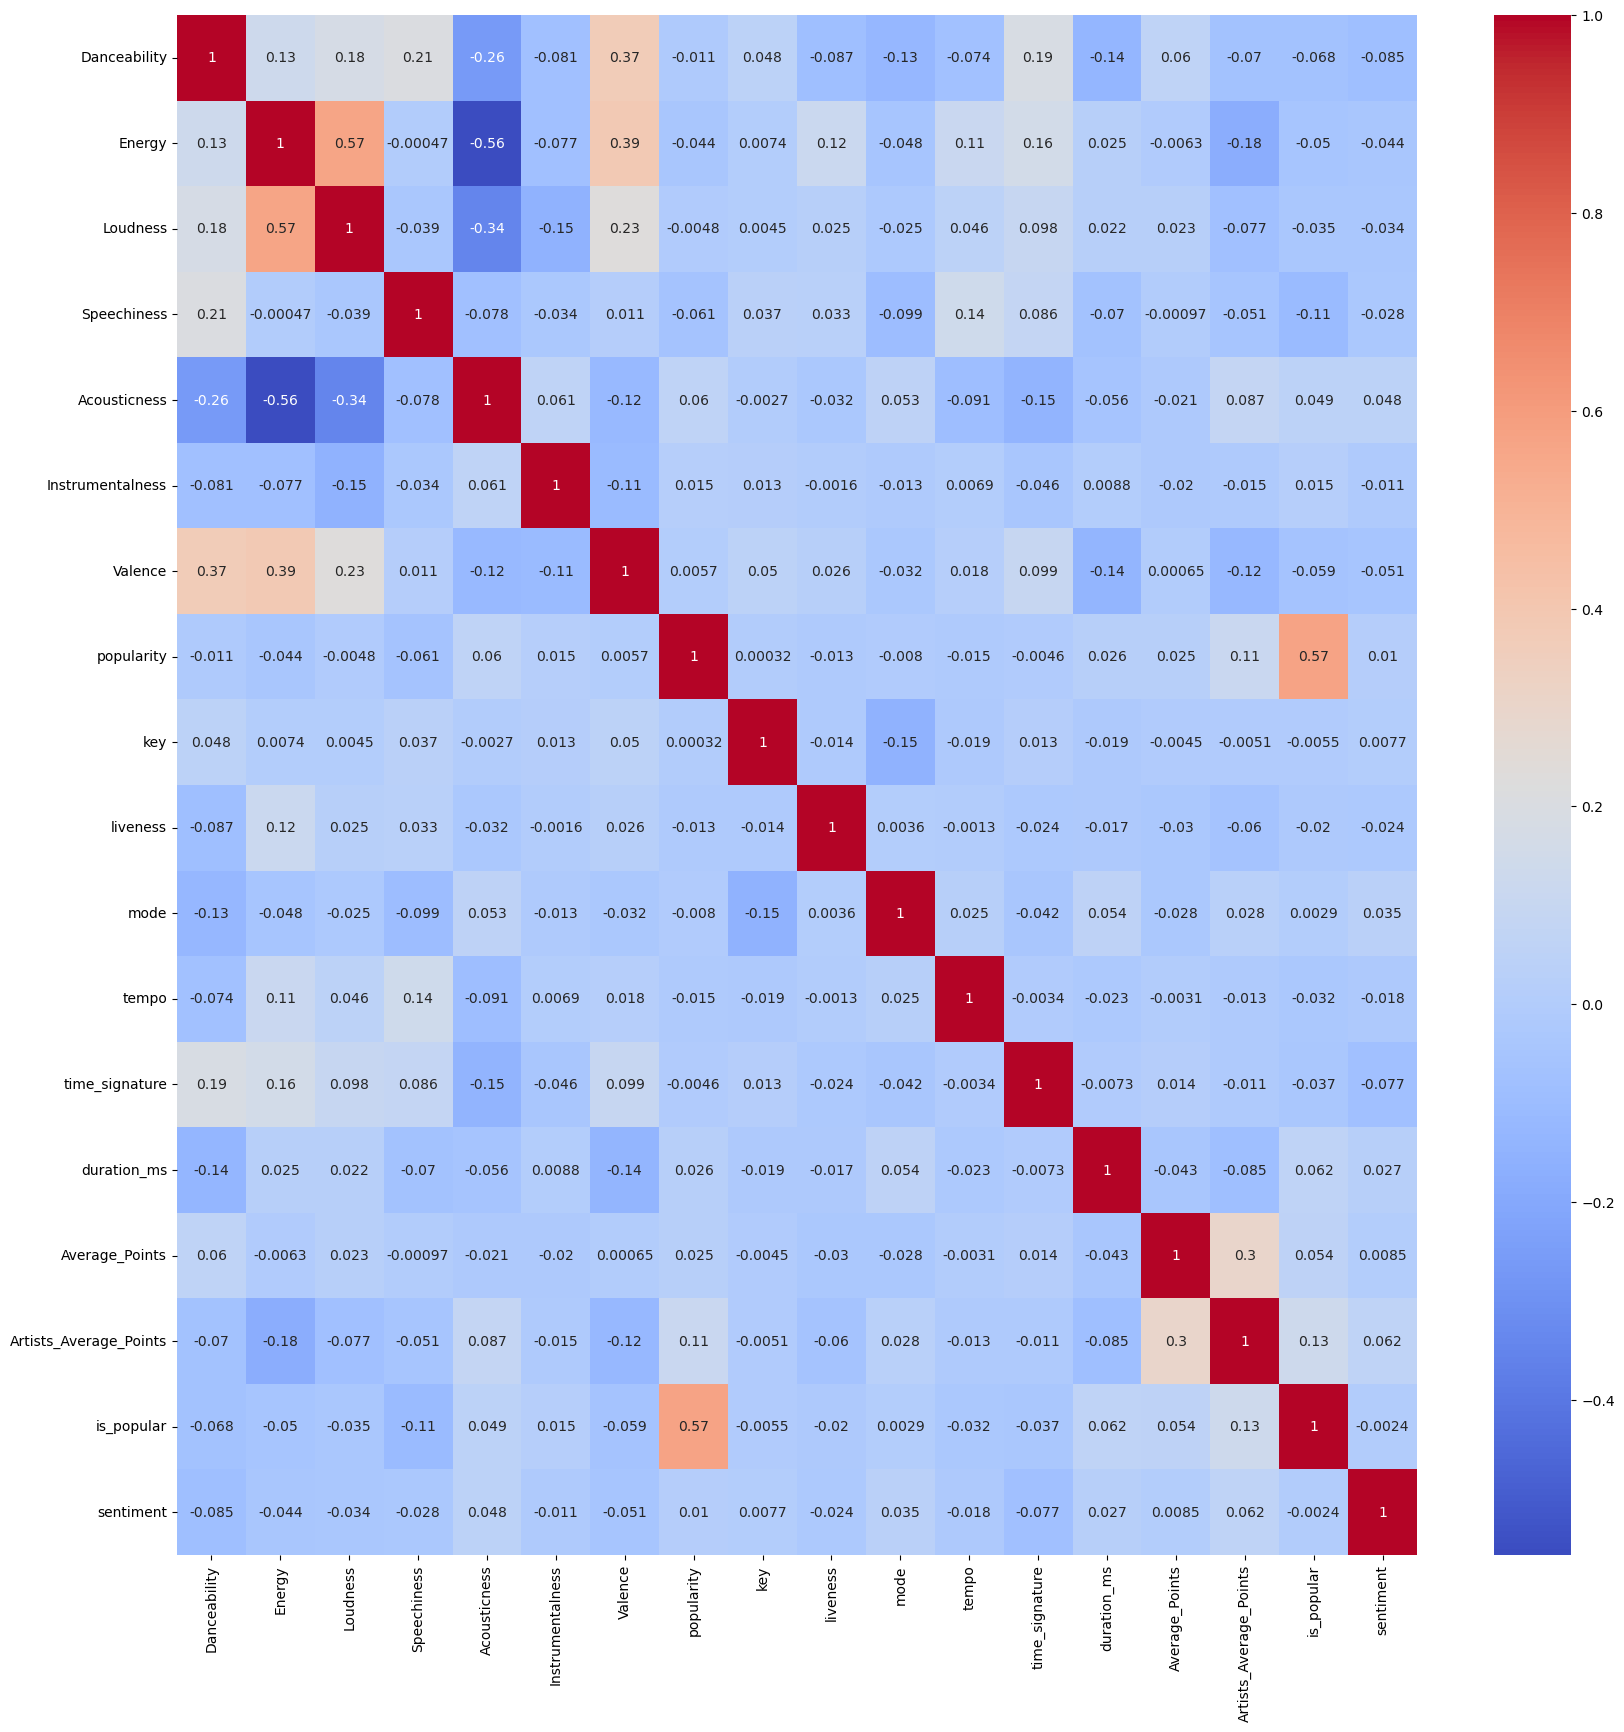

In [8]:
# print correlation matrix

corr = monthly_unique_songs.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

Index(['Title', 'Artists', 'Danceability', 'Energy', 'Loudness', 'Speechiness',
       'Acousticness', 'Instrumentalness', 'Valence', 'Continent', 'id',
       'popularity', 'key', 'liveness', 'mode', 'tempo', 'time_signature',
       'duration_ms', 'Data_Month', 'Average_Points', 'Artists_Average_Points',
       'General_Genre', 'is_popular', 'sentiment', 'polarity'],
      dtype='object')


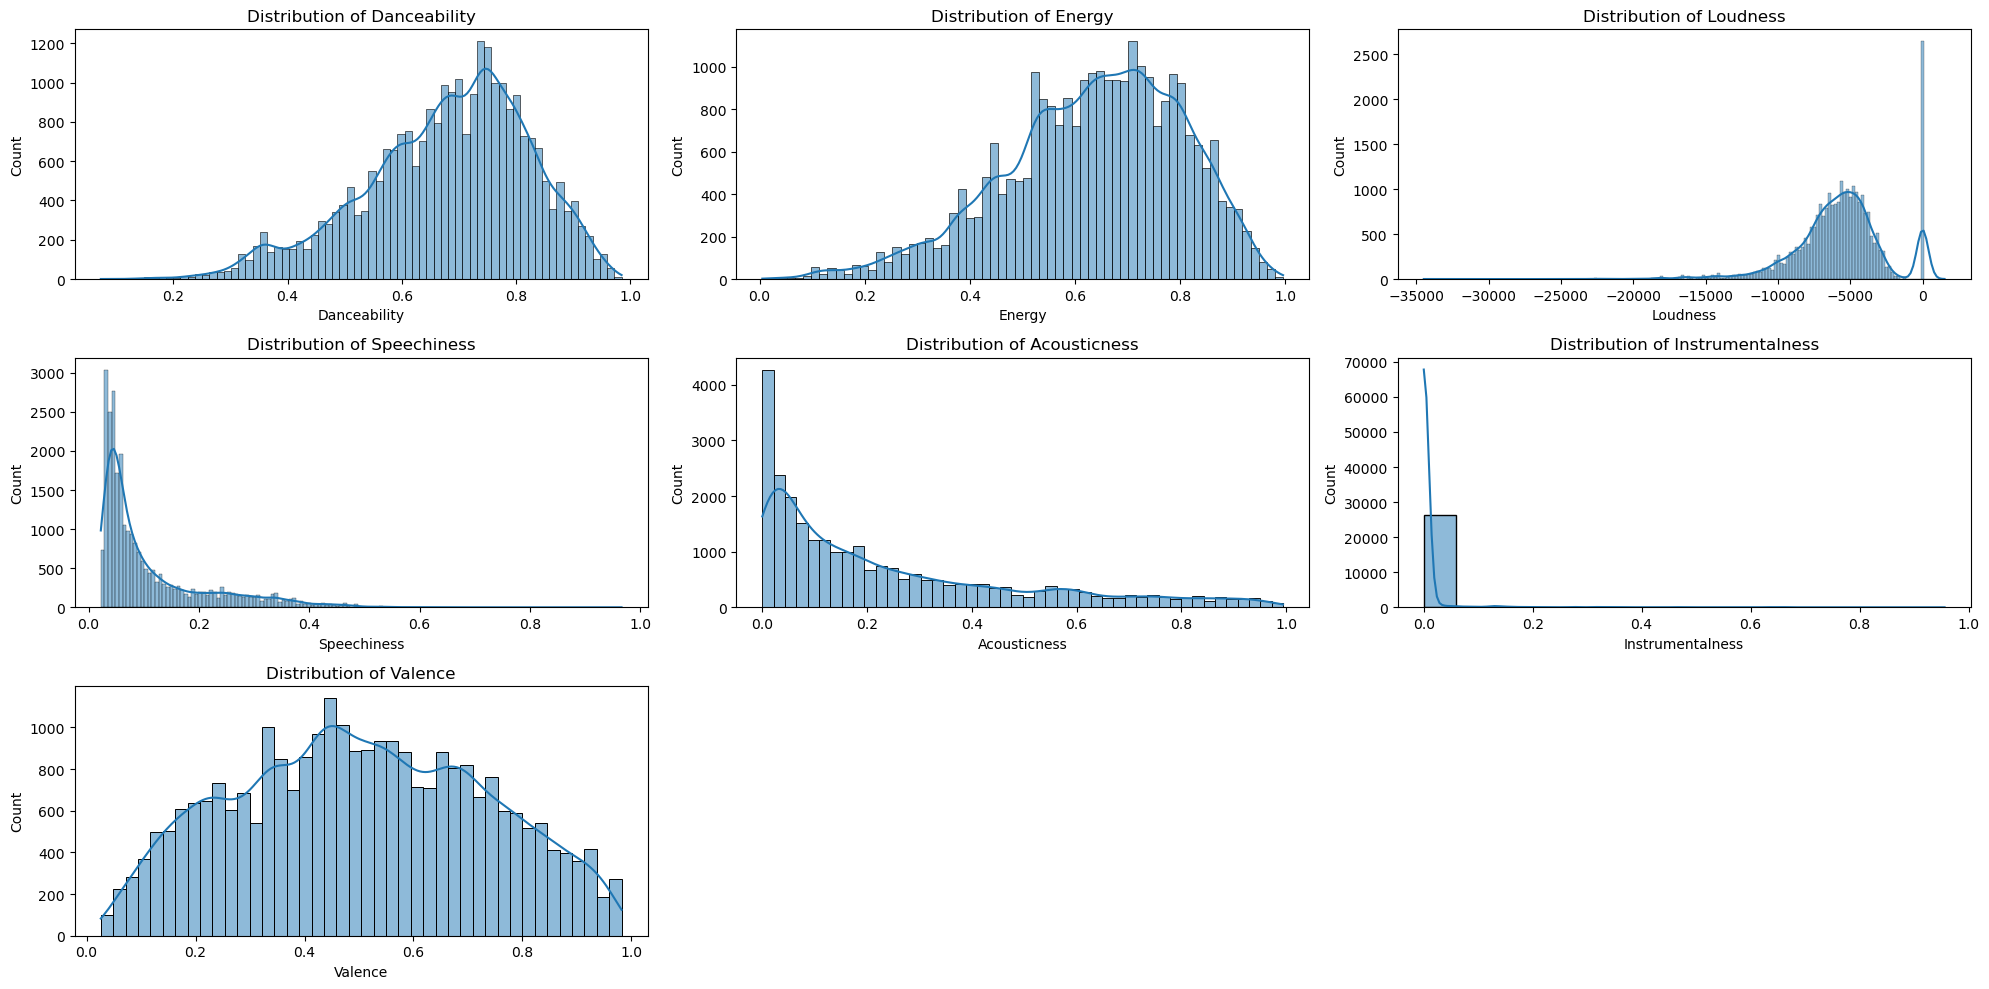

               Continent
Anglo-America      15230
Europe              6323
Latin-America       4107
Asia                 767
Oceania              592
Africa               114
Unknown                5


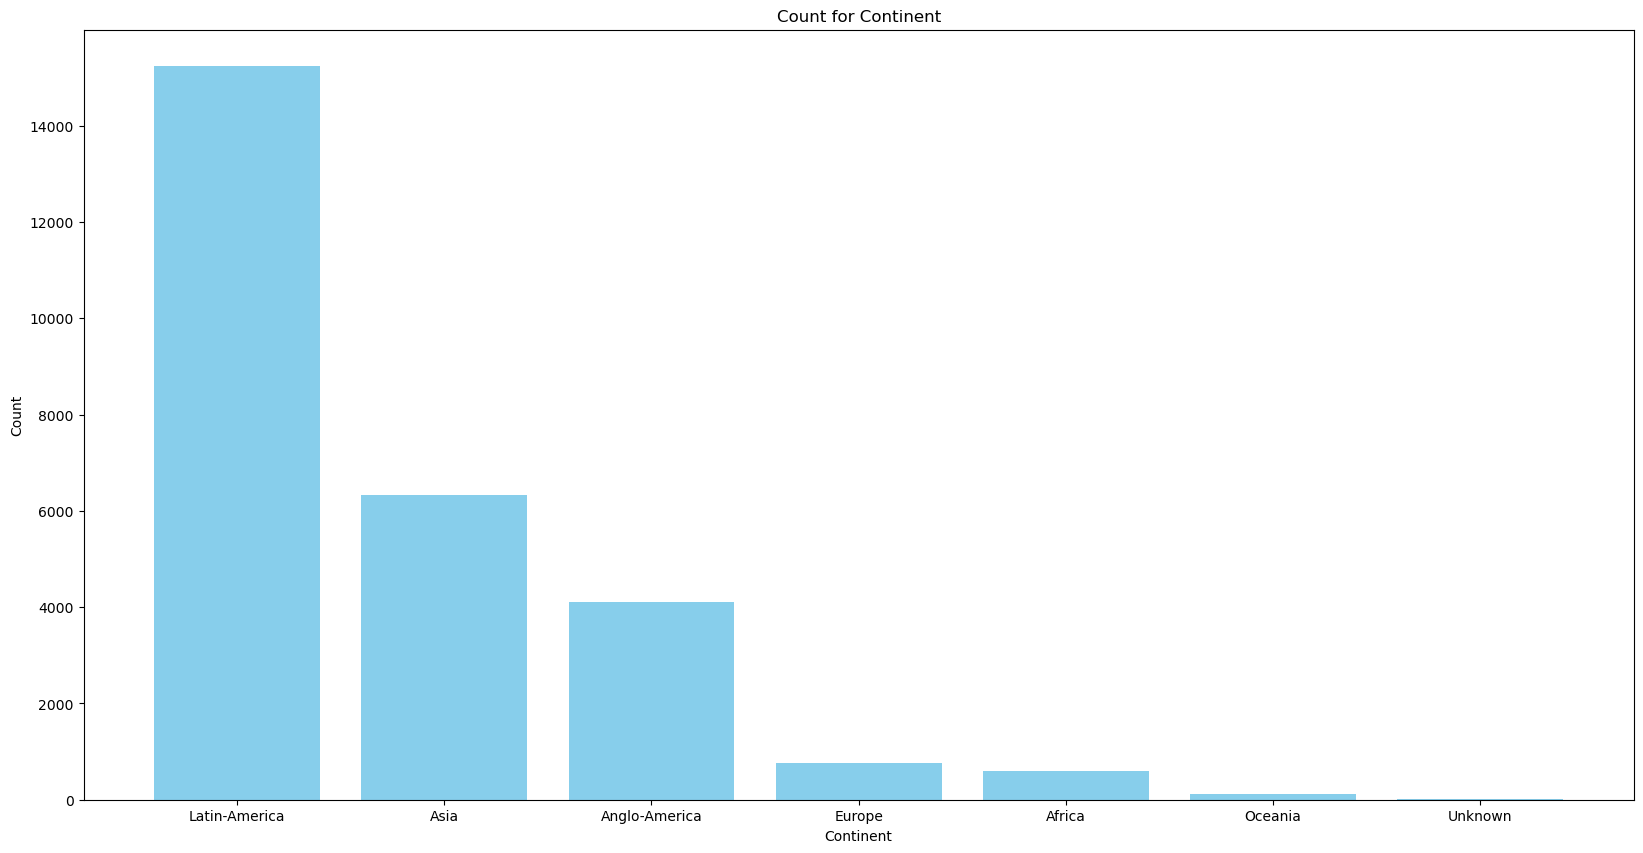

In [9]:
song_attributes = ['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Valence']

def plot_distribution(data: pd.DataFrame, columns: list = song_attributes):

    # plot the distribution of each song attribute in subplots
    plt.figure(figsize=(20, 10))
    for i, attribute in enumerate(columns, 1):
        plt.subplot(3, 3, i)
        sns.histplot(data=data, x=attribute, kde=True)
        plt.title(f'Distribution of {attribute}')
    plt.tight_layout()
    plt.show()
    
def plot_correlation(data: pd.DataFrame):
    # plot the correlation matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(data.corr(), annot=True, cmap='viridis')
    plt.title('Correlation Matrix')
    plt.show()
    

def normalize(data: pd.DataFrame, columns: list = song_attributes):
    # normalize the data
    scaler = MinMaxScaler()
    data[columns] = scaler.fit_transform(data[columns])
    return data

def remove_outliers(data: pd.DataFrame, columns: list = song_attributes):
    model = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(0.05), max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=1)
    model.fit(data[columns])
    data['anomaly'] = pd.Series(model.predict(data[columns]))
    data = data[data['anomaly'] == 1]
    data = data.drop(columns=['anomaly'])
    data.reset_index(drop=True, inplace=True)
    return data

def plot_count_for_continent(data: pd.DataFrame):
    continents = data['Continent'].unique()
    print(pd.DataFrame(data['Continent'].value_counts()))
    plt.figure(figsize=(20, 10))
    # for bar plot in one graph
    plt.bar(continents, data['Continent'].value_counts(), color='skyblue')
    plt.xlabel('Continent')
    plt.ylabel('Count')
    plt.title('Count for Continent')
    plt.show()
    
    
# print("Before removing outliers: ", normalized_monthly_unique_songs.shape)
# cleaned_song_data = remove_outliers(normalized_monthly_unique_songs, song_attributes)
# print("After removing outliers: ", cleaned_song_data.shape)
print(monthly_unique_songs.columns)
plot_distribution(monthly_unique_songs, song_attributes)
plot_count_for_continent(monthly_unique_songs)

refined_song_attributes = ['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Valence']

## Reduce dimensionalities by PCA to reduce noise

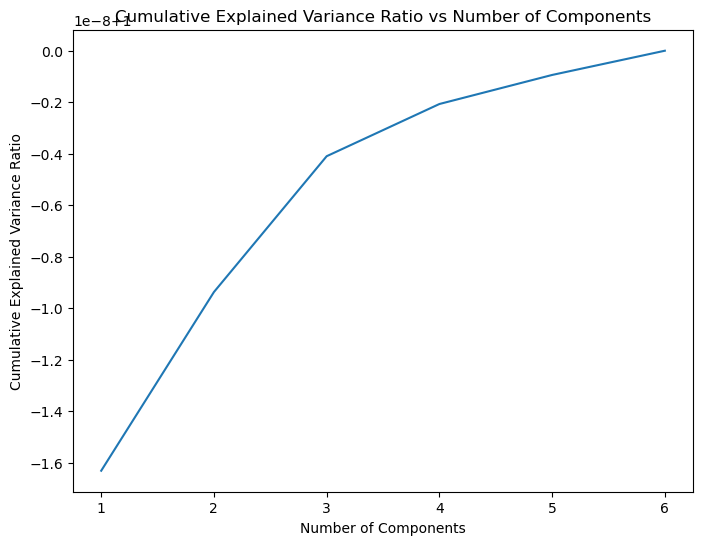

Knee Point: 3
Explained Variance Ratio: 0.9999999959013326


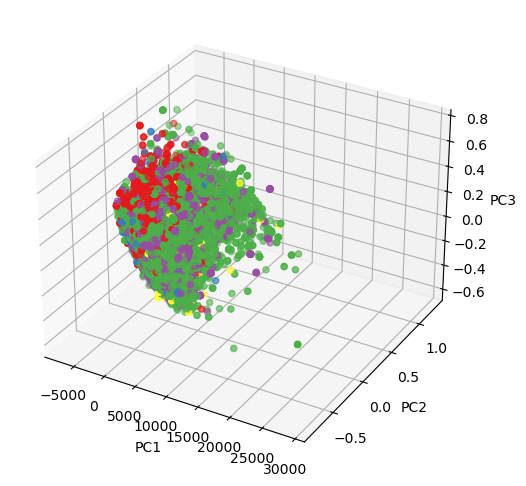

(27138, 3) (27138, 25)


In [10]:
# pca
def pca(data: pd.DataFrame, target_columns: list = song_attributes, n_components: int = 2):
    pca = PCA(n_components=n_components)

    pca_data = pca.fit_transform(data[target_columns])

    pca_data = pd.DataFrame(pca_data, columns=[f'PC{i}' for i in range(1, n_components+1)])
    return pca_data
    
def get_knee_n(data: pd.DataFrame, target_columns: list = song_attributes):
    number_of_components = len(target_columns)
    pca = PCA(n_components=number_of_components)
    pca.fit_transform(data[target_columns])
    cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
    # plot the cumulative variance ratio
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(cumulative_variance_ratio)+1), cumulative_variance_ratio)
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Cumulative Explained Variance Ratio vs Number of Components')
    plt.show()
    
    kn = KneeLocator(range(1, len(cumulative_variance_ratio)+1), cumulative_variance_ratio, curve='concave', direction='increasing')
    print(f'Knee Point: {kn.knee}')
    print(f'Explained Variance Ratio: {cumulative_variance_ratio[kn.knee-1]}')
    return kn.knee

def plot_pca_graph(pca_data: pd.DataFrame, data: pd.DataFrame, label_column: str = 'Continent', n_components: int = 2):
    # plot 3d scatter plot
    if n_components == 3:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        # map the continent into colors
        color_map = ListedColormap(plt.cm.Set1.colors[:len(data[label_column].unique())])
        ax.scatter(pca_data['PC1'], pca_data['PC2'], pca_data['PC3'], c=data[label_column].map({continent: i for i, continent in enumerate(data[label_column].unique())}), cmap=color_map)
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        plt.show()
        
        
n = get_knee_n(monthly_unique_songs, refined_song_attributes)
pca_data = pca(monthly_unique_songs, refined_song_attributes, n_components=n)
plot_pca_graph(pca_data, monthly_unique_songs, label_column='Continent', n_components=n)
pca_data.head()
print(pca_data.shape, monthly_unique_songs.shape)

In [11]:
# put the pca data into the original data
monthly_unique_songs.reset_index(drop=True, inplace=True)
pca_monthly_unique_songs = pd.concat([monthly_unique_songs, pca_data], axis=1)
pca_monthly_unique_songs.head()


,Title,Artists,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,Continent,...,Data_Month,Average_Points,Artists_Average_Points,General_Genre,is_popular,sentiment,polarity,PC1,PC2,PC3
0,Ella Baila Sola,"Eslabon Armado, Peso Pluma",0.668,0.758,-5176.0,0.033,0.483,0.000,0.834,Latin-America,...,2023-05,199.586207,66.506683,corrido,1,0.0,neutral,-518.083981,0.017705,0.402266
1,WHERE SHE GOES,Bad Bunny,0.652,0.800,-4019.0,0.061,0.143,0.629,0.234,Latin-America,...,2023-05,198.909091,75.923013,rap,1,0.0,neutral,-1675.083981,0.068826,-0.279533
2,La Bebe - Remix,"Yng Lvcas, Peso Pluma",0.812,0.479,-5678.0,0.333,0.213,0.000,0.559,Latin-America,...,2023-05,197.724138,75.853741,reggae,1,0.0,neutral,-16.083977,-0.036850,0.050671
3,Cupid - Twin Ver.,FIFTY FIFTY,0.783,0.592,-8332.0,0.033,0.435,0.000,0.726,Asia,...,2023-05,196.689655,126.928000,pop,1,0.0,neutral,2637.916020,-0.072397,0.307475
4,un x100to,"Grupo Frontera, Bad Bunny",0.569,0.724,-4076.0,0.047,0.228,0.000,0.562,Latin-America,...,2023-05,198.793103,76.654777,rap,1,0.0,neutral,-1618.083981,0.028260,0.023042


In [12]:
# Performing one-hot encoding for the specified columns
one_hot_continent = pd.get_dummies(pca_monthly_unique_songs['Continent'], prefix='Continent')
one_hot_genre = pd.get_dummies(pca_monthly_unique_songs['General_Genre'], prefix='General_Genre')

# label encoding for time_signature, key, polarity
time_label_encoder = LabelEncoder()
time_label_encoder.fit(pca_monthly_unique_songs['time_signature'])
pca_monthly_unique_songs['time_signature'] = time_label_encoder.transform(pca_monthly_unique_songs['time_signature'])
key_label_encoder = LabelEncoder()
key_label_encoder.fit(pca_monthly_unique_songs['key'])
pca_monthly_unique_songs['key'] = key_label_encoder.transform(pca_monthly_unique_songs['key'])
polarity_label_encoder = LabelEncoder()
polarity_label_encoder.fit(pca_monthly_unique_songs['polarity'])
pca_monthly_unique_songs['polarity'] = polarity_label_encoder.transform(pca_monthly_unique_songs['polarity'])


NORMALIZE = True

if NORMALIZE:
    # normalize Artists_Average_Points, tempo, Loudness, key, duration_ms
    normalizer = StandardScaler()
    for column in ['Artists_Average_Points', 'tempo', 'Loudness', 'duration_ms', 'key']:
        pca_monthly_unique_songs[column] = normalizer.fit_transform(pca_monthly_unique_songs[[column]])

# Concatenating the one-hot encoded columns with the original dataframe
pca_monthly_unique_songs = pd.concat([pca_monthly_unique_songs, one_hot_continent, one_hot_genre], axis=1)
pca_monthly_unique_songs.columns[:30], pca_monthly_unique_songs.head(), pca_monthly_unique_songs['polarity']

(Index(['Title', 'Artists', 'Danceability', 'Energy', 'Loudness', 'Speechiness',
        'Acousticness', 'Instrumentalness', 'Valence', 'Continent', 'id',
        'popularity', 'key', 'liveness', 'mode', 'tempo', 'time_signature',
        'duration_ms', 'Data_Month', 'Average_Points', 'Artists_Average_Points',
        'General_Genre', 'is_popular', 'sentiment', 'polarity', 'PC1', 'PC2',
        'PC3', 'Continent_Africa', 'Continent_Anglo-America'],
       dtype='object'),
                Title                     Artists  Danceability  Energy  \
 0    Ella Baila Sola  Eslabon Armado, Peso Pluma         0.668   0.758   
 1     WHERE SHE GOES                   Bad Bunny         0.652   0.800   
 2    La Bebe - Remix       Yng Lvcas, Peso Pluma         0.812   0.479   
 3  Cupid - Twin Ver.                 FIFTY FIFTY         0.783   0.592   
 4          un x100to   Grupo Frontera, Bad Bunny         0.569   0.724   
 
    Loudness  Speechiness  Acousticness  Instrumentalness  Valence  \
 

In [13]:
# preview existing columns
print(pca_monthly_unique_songs.columns[:30], pca_monthly_unique_songs.head())
feature_columns = ['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 
                           'Instrumentalness', 'Valence', 'tempo', 'key', 'mode', 'time_signature', 'Artists_Average_Points', 'polarity']

IS_PCA = True
if IS_PCA:
    feature_columns = ['PC1', 'PC2', 'PC3', 'tempo', 'key', 'mode', 'time_signature', 'Artists_Average_Points', 'polarity']

target_column = 'is_popular'

print(pca_monthly_unique_songs)

# helper function to plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Plot the learning curves
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Index(['Title', 'Artists', 'Danceability', 'Energy', 'Loudness', 'Speechiness',
       'Acousticness', 'Instrumentalness', 'Valence', 'Continent', 'id',
       'popularity', 'key', 'liveness', 'mode', 'tempo', 'time_signature',
       'duration_ms', 'Data_Month', 'Average_Points', 'Artists_Average_Points',
       'General_Genre', 'is_popular', 'sentiment', 'polarity', 'PC1', 'PC2',
       'PC3', 'Continent_Africa', 'Continent_Anglo-America'],
      dtype='object')                Title                     Artists  Danceability  Energy  \
0    Ella Baila Sola  Eslabon Armado, Peso Pluma         0.668   0.758   
1     WHERE SHE GOES                   Bad Bunny         0.652   0.800   
2    La Bebe - Remix       Yng Lvcas, Peso Pluma         0.812   0.479   
3  Cupid - Twin Ver.                 FIFTY FIFTY         0.783   0.592   
4          un x100to   Grupo Frontera, Bad Bunny         0.569   0.724   

   Loudness  Speechiness  Acousticness  Instrumentalness  Valence  \
0  0.168438      

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X = pca_monthly_unique_songs[feature_columns]
y = pca_monthly_unique_songs[target_column]

# print the count when y is na
print("Total count of na in y: ", y.isna().sum())

X = X.fillna(X.mean())

# Splitting the data into training and testing sets (60% training, 20% validation, 20% testing)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

Total count of na in y:  0


((16282, 9), (5428, 9), (16282,), (5428,))

In [15]:
from sklearn.metrics import confusion_matrix
svm_model = SVC(random_state=42, class_weight='balanced')
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)


print(pd.DataFrame(conf_matrix, columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1']))
print('\nAccuracy:', accuracy)
print('\nClassification Report:\n', class_report)

          Predicted 0  Predicted 1
Actual 0         1577         2097
Actual 1          720         1034

Accuracy: 0.48102431834929993

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.43      0.53      3674
           1       0.33      0.59      0.42      1754

    accuracy                           0.48      5428
   macro avg       0.51      0.51      0.48      5428
weighted avg       0.57      0.48      0.49      5428



## We choose Artists_Average_Points, tempo, Loudness, Danceability, Valence, Energy and Acousticness here

Accuracy: 0.9683124539425203
AUC: 0.9879076458878657
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3674
           1       0.95      0.95      0.95      1754

    accuracy                           0.97      5428
   macro avg       0.96      0.96      0.96      5428
weighted avg       0.97      0.97      0.97      5428

                        importance
Artists_Average_Points    0.183106
PC2                       0.174751
tempo                     0.172329
PC1                       0.168674
PC3                       0.165199
key                       0.081352
polarity                  0.021763
mode                      0.020380
time_signature            0.012446
--------------------Validation Results--------------------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3723
           1       0.95      0.95      0.95      1705

    accuracy                           0.97    

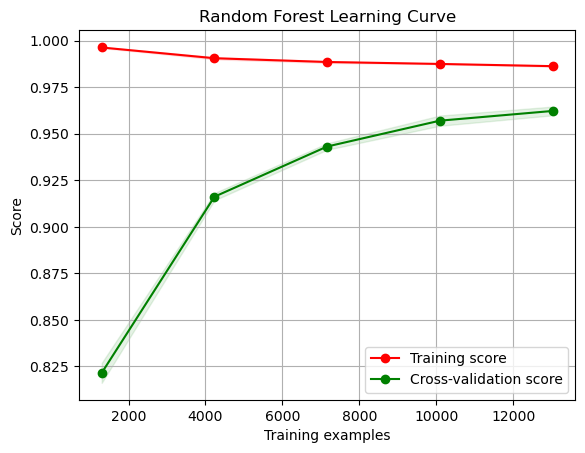

Number of Trees:  100
Max Depth:  None


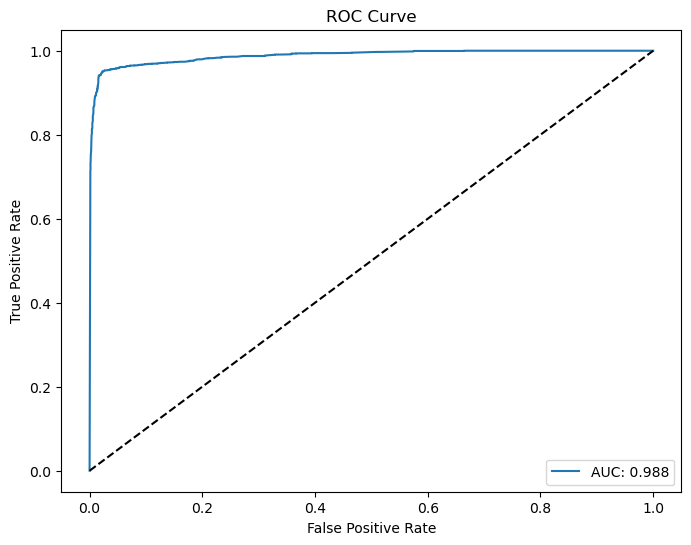

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report

rf_model = RandomForestClassifier(random_state=42, class_weight='balanced_subsample', criterion='entropy', max_features='auto')
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
class_report_rf = classification_report(y_test, y_pred_rf)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)

print(f"Accuracy: {accuracy_rf}", f"AUC: {roc_auc_rf}", sep='\n')
print(classification_report(y_test, y_pred_rf))
feature_importances = pd.DataFrame(rf_model.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

# final validation
y_pred_rf_val = rf_model.predict(X_val)
print("-"*20 + "Validation Results" + "-"*20)
print(classification_report(y_val, y_pred_rf_val))

# confusion matrix
print(pd.DataFrame(confusion_matrix(y_val, y_pred_rf_val), columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1']))

cv_results = cross_val_score(rf_model, X_train, y_train, cv=5)
print(cv_results)
print(np.mean(cv_results))
# print training accuracy vs validation accuracy
print("Training Accuracy: ", rf_model.score(X_train, y_train))
print("Validation Accuracy: ", rf_model.score(X_val, y_val))

plot_learning_curve(rf_model, "Random Forest Learning Curve", X_train, y_train, cv=5)
plt.show()

# print number of trees
print("Number of Trees: ", rf_model.n_estimators)
# print max depth
print("Max Depth: ", rf_model.max_depth)

# plot roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC: {roc_auc_rf:.3f}')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

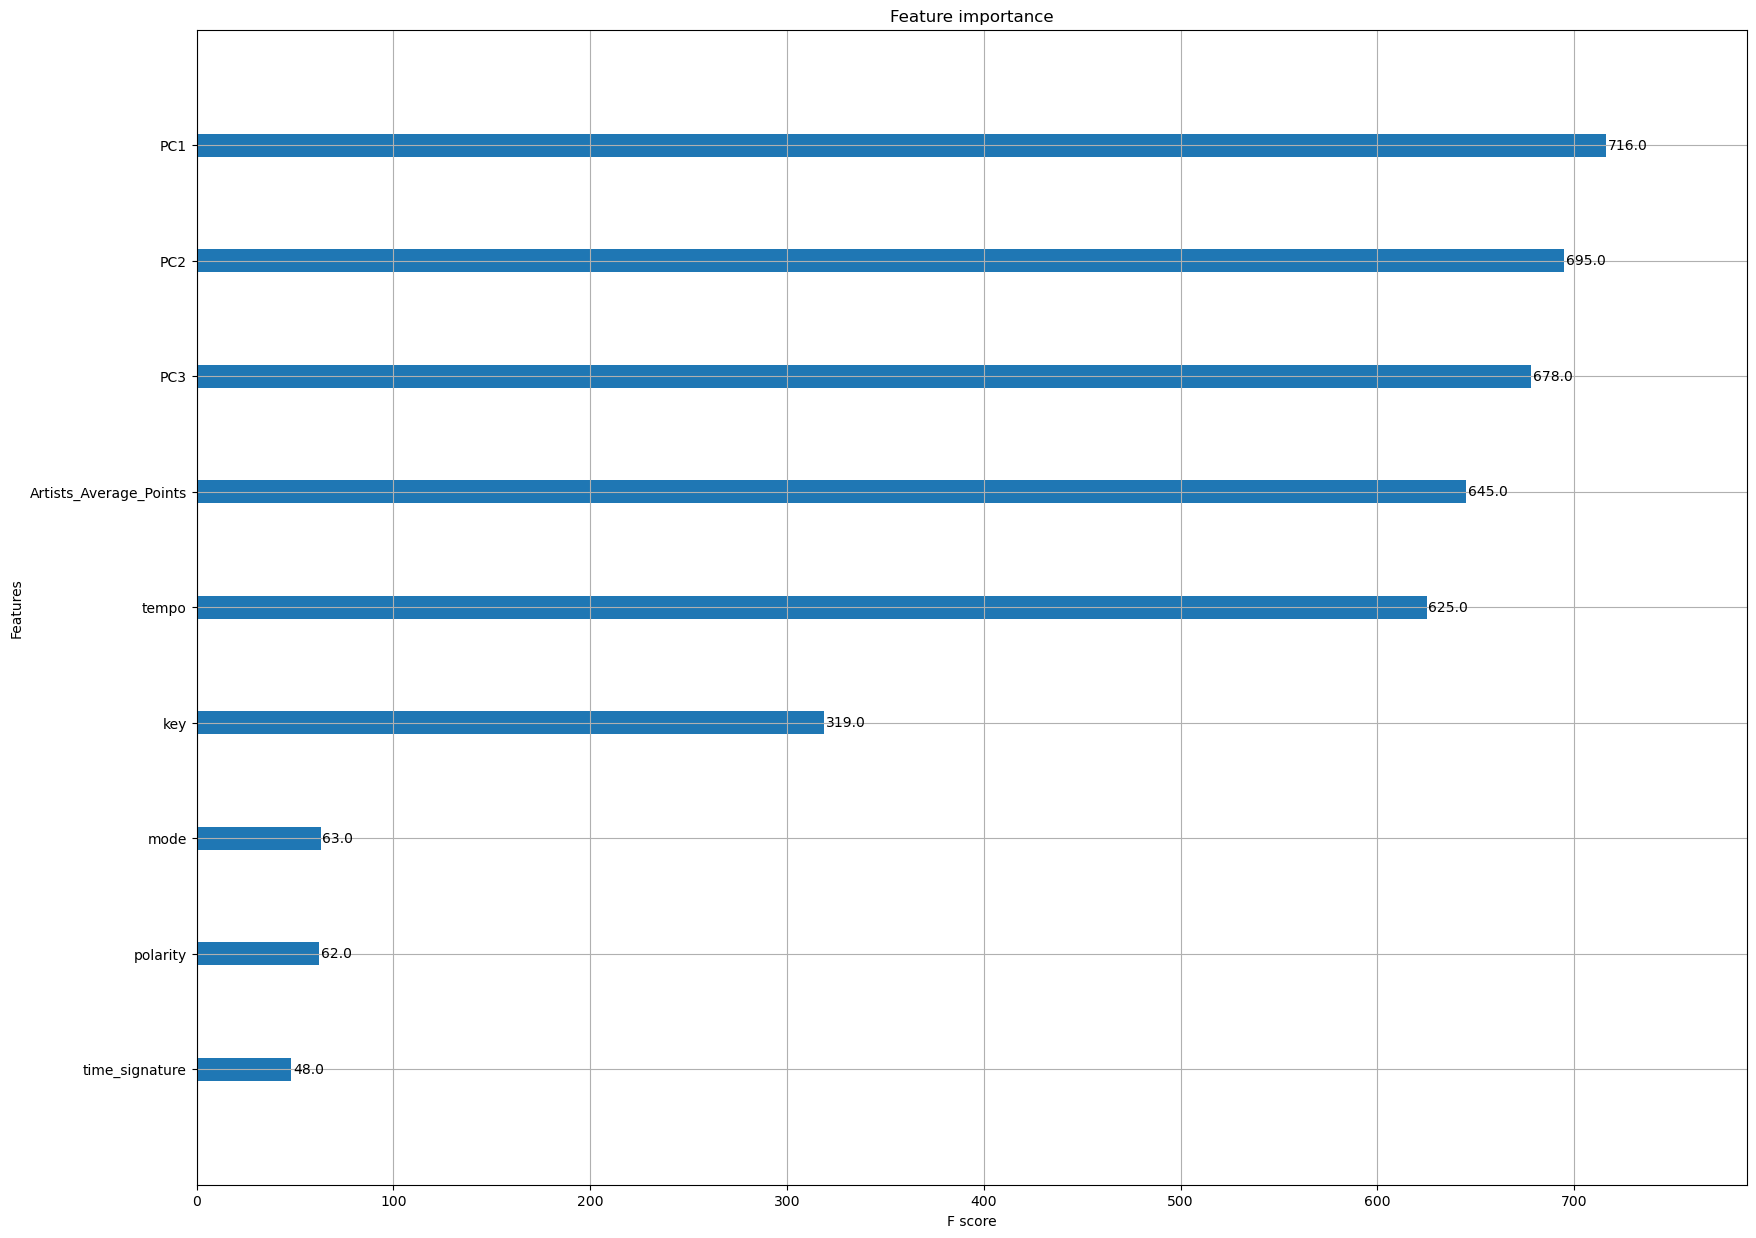

In [17]:
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

model = XGBClassifier()
model.fit(X_train, y_train)

# plot feature importance
ax = plot_importance(model)
fig = ax.figure
fig.set_size_inches(20, 15)
#plot_importance(model)
pyplot.show()

In [18]:
from sklearn.linear_model import LogisticRegression

log_reg_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')

log_reg_model.fit(X_train, y_train)

y_pred_log_reg = log_reg_model.predict(X_test)

accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
class_report_log_reg = classification_report(y_test, y_pred_log_reg)

y_prob_log_reg = log_reg_model.predict_proba(X_test)[:, 1]
roc_auc_log_reg = roc_auc_score(y_test, y_prob_log_reg)

print(f"Accuracy: {accuracy_log_reg}", f"AUC: {roc_auc_log_reg}", sep='\n')
print(classification_report(y_test, y_pred_log_reg))

Accuracy: 0.5545320560058954
AUC: 0.5894159643809718
              precision    recall  f1-score   support

           0       0.73      0.54      0.62      3674
           1       0.38      0.59      0.46      1754

    accuracy                           0.55      5428
   macro avg       0.56      0.56      0.54      5428
weighted avg       0.62      0.55      0.57      5428



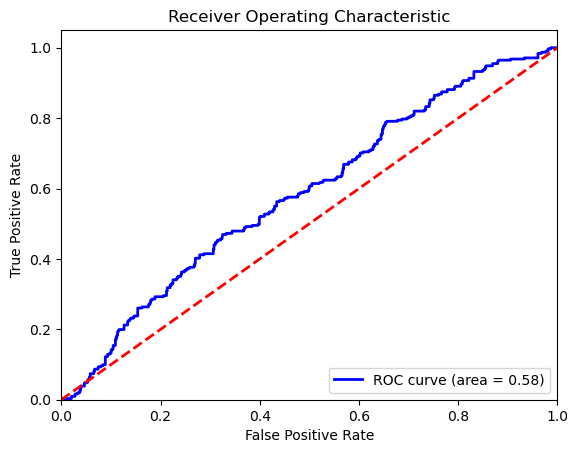

In [19]:
import matplotlib.pyplot as plt

log_reg_model_simplified = LogisticRegression(random_state=42, max_iter=1000)
log_reg_model_simplified.fit(X_train.iloc[:1000], y_train.iloc[:1000])  # Using a subset of the data

y_prob_simplified = log_reg_model_simplified.predict_proba(X_test.iloc[:1000])[:, 1]
fpr_simplified, tpr_simplified, thresholds_simplified = roc_curve(y_test.iloc[:1000], y_prob_simplified)
roc_auc_simplified = auc(fpr_simplified, tpr_simplified)

# Plotting the ROC Curve
plt.figure()
plt.plot(fpr_simplified, tpr_simplified, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_simplified)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Neural network

In [24]:
refined_feature_columns = ['Artists_Average_Points', 'tempo', 'Loudness', 'Danceability', 'Valence', 'Speechiness', 'Energy', 'Acousticness', 'key']

# # resample is_popular data to balance the data
# is_popular_0 = pca_monthly_unique_songs[pca_monthly_unique_songs['is_popular'] == 0]
# is_popular_1 = pca_monthly_unique_songs[pca_monthly_unique_songs['is_popular'] == 1]
# if len(is_popular_0) > len(is_popular_1):
#     is_popular_0 = resample(is_popular_0, replace=False, n_samples=len(is_popular_1), random_state=42)
# else:
#     is_popular_1 = resample(is_popular_1, replace=False, n_samples=len(is_popular_0), random_state=42)
# pca_monthly_unique_songs_balanced = pd.concat([is_popular_0, is_popular_1])

# print(pca_monthly_unique_songs_balanced['is_popular'].value_counts())

# if IS_PCA:
#     refined_feature_columns = ['PC1', 'PC2', 'PC3', 'tempo', 'key', 'mode', 'time_signature', 'Artists_Average_Points', 'polarity']

X_refined = pca_monthly_unique_songs[refined_feature_columns]
y_refined = pca_monthly_unique_songs[target_column]

X_refined = X_refined.fillna(X_refined.mean())

# Splitting the data into training and testing sets (75% training, 25% testing)
X_train_refined, X_test_refined, y_train_refined, y_test_refined = train_test_split(X_refined, y_refined, test_size=0.25, random_state=42)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
------------------------------MLP------------------------------
Best parameters: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 32, 'hidden_layer_sizes': (256, 128, 64, 32, 16), 'max_iter': 1000, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001}, Best score: 0.8604700687686032, Best f1 score: 0.9239498894620486
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      4655
           1       0.89      0.87      0.88      2130

    accuracy                           0.92      6785
   macro avg       0.91      0.91      0.91      6785
weighted avg       0.92      0.92      0.92      6785



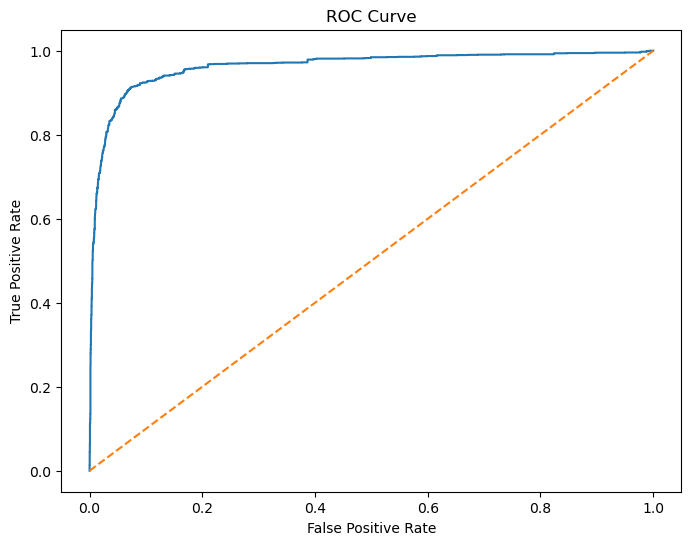

In [25]:

grid = {
    'hidden_layer_sizes': [(256, 128, 64, 32, 16)],
    'batch_size': [32],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.0001],
    'max_iter': [1000],
    'shuffle': [True],
    'tol': [0.0001],
}

mlp = MLPClassifier(random_state=42)
grid_search = GridSearchCV(mlp, grid, cv=2, scoring='f1', verbose=1, n_jobs=-1)
grid_search.fit(X_train_refined, y_train_refined)
chosen_params = grid_search.best_params_
print("-"*30 + "MLP" + "-"*30)
print(f"Best parameters: {chosen_params}, Best score: {grid_search.best_score_}, Best f1 score: {grid_search.best_estimator_.score(X_test_refined, y_test_refined)}")

print(classification_report(y_test_refined, grid_search.best_estimator_.predict(X_test_refined)))

fpr, tpr, threshold = roc_curve(y_test_refined, grid_search.best_estimator_.predict_proba(X_test_refined)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

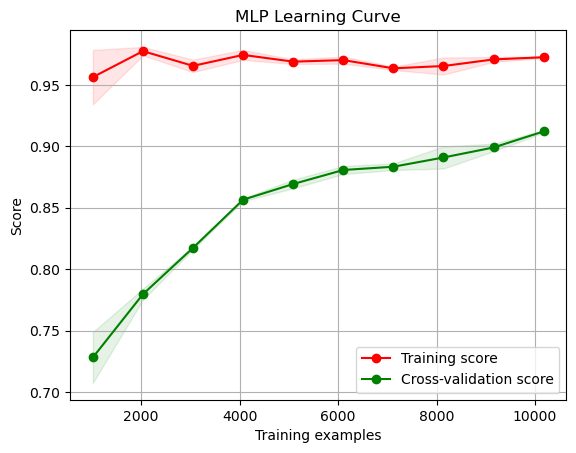

In [26]:

    
selected_model = grid_search.best_estimator_

plot_learning_curve(selected_model, "MLP Learning Curve", X_train_refined, y_train_refined, cv=2, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10))
plt.show()

In [27]:
# show the confusion matrix
conf_matrix = confusion_matrix(y_test_refined, selected_model.predict(X_test_refined))
print(pd.DataFrame(conf_matrix, columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1']))
# print auc score
print(roc_auc_score(y_test_refined, selected_model.predict_proba(X_test_refined)[:, 1]))

          Predicted 0  Predicted 1
Actual 0         4424          231
Actual 1          285         1845
0.9629868937938406
